## Capstone Project - Toxic Comments Classification

In [1]:
# import libraries for data manipulation and visulisation
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Input all data files needed for the project
path = './input/'
EMBEDDING_FILE = path + 'glove.6B.50d.txt'
TRAIN_DATA_FILE = path + 'train.csv'
TEST_DATA_FILE = path + 'test.csv'
SUBMISSION_SAMPLE_FILE = path + 'sample_submission.csv'

train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)
sample_submission = pd.read_csv(SUBMISSION_SAMPLE_FILE)

### Exploratory Data Analysis

In [4]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [21]:
# sampling of the data
train.loc[[0], ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [23]:
print train.iloc[0].comment_text

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [24]:
# sampling of the data
train.loc[[6], ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [25]:
print train.iloc[6].comment_text

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
train.describe(include=['O'])

,id,comment_text
count,159571,159571
unique,159571,159571
top,1bb4921cd8fefd3c,"Be quit, stop using poor excuses with the abov..."
freq,1,1


In [6]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [28]:
# sampling of the data
test.loc[[0], ['id', 'comment_text']]

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...


In [30]:
print test.iloc[0].comment_text

Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


In [8]:
test.describe(include=['O'])

,id,comment_text
count,153164,153164
unique,153164,153164
top,3f9fefa1b975e1e0,:Time reversal? Entropy of the universe? This ...
freq,1,1


In [31]:
# target variables for training
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[class_names].values
# extract and combine the raw text of comments for text preprocessing
train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

In [11]:
# statistically explore the length of the comments
lens = all_text.str.len()
lens.min(), lens.max(), lens.mean(), lens.std()

(1, 13493, 382.36360816665865, 605.2652353705764)

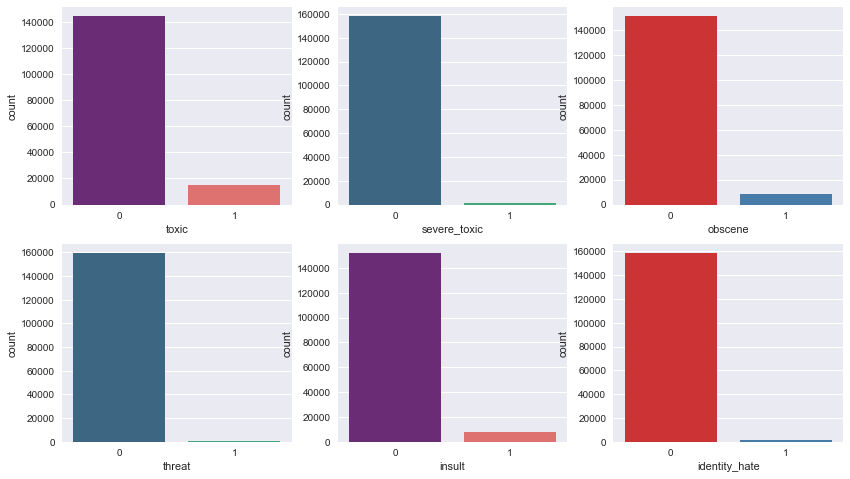

In [43]:
# visualise the value distribution of each target variable
fig,ax = plt.subplots(2,3,figsize=(14,8))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6)

In [13]:
# build the benchmark
y_zeros = np.zeros((test.shape[0], len(class_names)))
submission_bm = sample_submission.copy()
submission_bm[class_names] = y_zeros
submission_bm.to_csv('submission_bm.csv', index=False)

### Text Preprocessing - Vectorisation
Vectorise the raw text to the sparse matrix of TF-IDF features

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# using the word 1-gram to construct vectorised features
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

# using the character 1-gram to 5-gram to construct vectorised features
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 5),
    max_features=20000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

# concatenate the character and word features
train_vectorized_features = sparse.hstack([train_char_features, train_word_features])
test_vectorized_features = sparse.hstack([test_char_features, test_word_features])

In [15]:
train_vectorized_features.shape, test_vectorized_features.shape

((159571, 30000), (153164, 30000))

### Feature Engineering - creating new features

In [16]:
all_new_features = pd.DataFrame()

# compute the length of each comment as a new feature
all_new_features['total_length'] = all_text.apply(len)
# compute the proportion of capitals in each comment
all_new_features['capitals'] = all_text.apply(lambda comment: sum(1 for c in comment if c.isupper()))
all_new_features['caps_vs_length'] = all_new_features.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
# compute the number of exclamation marks in each comment
all_new_features['num_exclamation_marks'] = all_text.apply(lambda comment: comment.count('!'))
# compute the number of question marks in each comment
all_new_features['num_question_marks'] = all_text.apply(lambda comment: comment.count('?'))
# compute the number of common punctuation in each comment
all_new_features['num_punctuation'] = all_text.apply(lambda comment: sum(comment.count(w) for w in '.,;:""\'\'[]{}()_-'))
#compute the number of unique words in each comment
all_new_features['num_unique_words'] = all_text.apply(lambda comment: len(set(w for w in comment.split())))

all_new_features.head()

,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_unique_words
0,264,17,0.064394,0,1,12,41
1,112,8,0.071429,1,0,13,17
2,233,4,0.017167,0,0,8,39
3,622,11,0.017685,0,0,28,82
4,67,2,0.029851,0,1,5,13


In [17]:
# features normalisation
from sklearn.preprocessing import MinMaxScaler

features = all_new_features.columns.values
scaler = MinMaxScaler()
X = scaler.fit_transform(all_new_features)
X_df = pd.DataFrame(X, columns = features)
X_df.head()

,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_unique_words
0,0.019493,0.003427,0.064394,0.000000,0.000868,0.003745,0.048780
1,0.008227,0.001613,0.071429,0.000201,0.000000,0.004057,0.019512
2,0.017195,0.000806,0.017167,0.000000,0.000000,0.002497,0.046341
3,0.046027,0.002218,0.017685,0.000000,0.000000,0.008739,0.098780
4,0.004892,0.000403,0.029851,0.000000,0.000868,0.001561,0.014634


In [62]:
# split the new feature dataframe into the train and test sets
train_new_features = X_df[:159571]
test_new_features = X_df[159571:]
train_new_features.shape, test_new_features.shape

((159571, 7), (153164, 7))

Now we'll calculate the correlation between the added features and six target variables to determine the importance of these features:

In [19]:
rows = [{c:train_new_features[f].corr(train[c]) for c in class_names} for f in features]
train_correlations = pd.DataFrame(rows, index=features)
train_correlations

,identity_hate,insult,obscene,severe_toxic,threat,toxic
total_length,-0.013670,-0.045128,-0.043010,0.010021,-0.007993,-0.054582
capitals,0.053586,0.075972,0.081716,0.143426,0.033579,0.091206
caps_vs_length,0.093839,0.170635,0.182676,0.169309,0.055571,0.221127
num_exclamation_marks,0.006005,0.027010,0.024362,0.060578,0.034202,0.037337
num_question_marks,-0.000516,0.004859,0.005404,-0.004541,-0.003949,0.027820
num_punctuation,-0.026167,-0.060542,-0.055342,-0.020787,-0.012857,-0.071767
num_unique_words,-0.032779,-0.080929,-0.080912,-0.048364,-0.020269,-0.096210


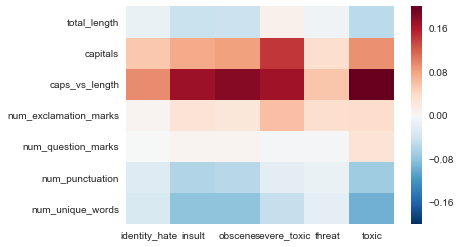

In [20]:
# plot a heatmap of the correlation
ax = sns.heatmap(train_correlations, vmin=-0.2, vmax=0.2, center=0.0)

Select new features based on the correlation and then form the final complete features

In [63]:
# remove less relevant features
train_new_features = train_new_features.drop(['total_length', 'capitals', 'num_question_marks'], axis=1)
test_new_features = test_new_features.drop(['total_length', 'capitals', 'num_question_marks'], axis=1)
train_new_features.shape, test_new_features.shape

((159571, 4), (153164, 4))

In [64]:
# concatenate the added features and TF-IDF features
X_train = sparse.hstack([train_vectorized_features, train_new_features])
X_test = sparse.hstack([test_vectorized_features, test_new_features])

### Building A Logistic Regression Model

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

In [65]:
## building a Logistic Regression model to do cross validation on the train set and predict on the test set
losses = [] # list the log loss of each target variable
predictions = {'id': test['id']} # prediction dictionary for the test dataset

for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(solver='sag')
    # the log loss by cross validation on the train dataset
    cv_loss = np.mean(cross_val_score(classifier, X_train, train_target, cv=3, scoring='roc_auc'))
    losses.append(cv_loss)
    print('CV score for class {} is {}'.format(class_name, cv_loss))
    # train the classifier and predict on the test set
    classifier.fit(X_train, train_target)
    predictions[class_name] = classifier.predict_proba(X_test)[:, 1]
# the average of log loss of each target variable
print('Total CV score is {}'.format(np.mean(losses)))

CV score for class toxic is 0.978716826567
CV score for class severe_toxic is 0.98917946852
CV score for class obscene is 0.989952201593
CV score for class threat is 0.989048348249
CV score for class insult is 0.982417830803
CV score for class identity_hate is 0.982757317032
Total CV score is 0.985345332127


In [66]:
# create a submission file to Kaggle competition for scoring
submission_lr = pd.DataFrame.from_dict(predictions)
submission_lr.to_csv('submission_lr.csv', index=False)

### Text Preprocessing - Tokenization
Tokenize the raw text comments in order to feed to the neural network model

In [23]:
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [74]:
# set some basic config parameters
max_features = 20000 # how many unique words to use
maxlen = 200 # max number of words in a comment to use
embed_size = 50  # how big is each word vector

In [75]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(all_text))
train_tokenized_features = tokenizer.texts_to_sequences(train_text)
test_tokenized_features = tokenizer.texts_to_sequences(test_text)

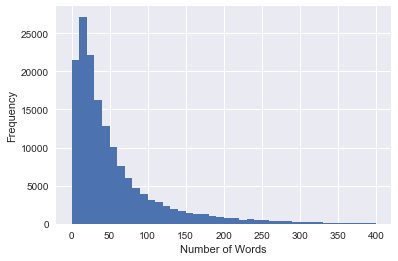

In [76]:
# explore the distribution of the number of words in comments
totalNumWords = [len(one_comment) for one_comment in train_tokenized_features]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [77]:
# padding the sequences
X_train = sequence.pad_sequences(train_tokenized_features, maxlen=maxlen)
X_test = sequence.pad_sequences(test_tokenized_features, maxlen=maxlen)

In [78]:
## add new features without normalisation to the tokenised feature sequences
# transform new features dataframe to numpy array
train_new_features = all_new_features[:159571]
test_new_features = all_new_features[159571:]
train_new_features = train_new_features.drop(['total_length', 'capitals', 'num_question_marks'], axis=1)
test_new_features = test_new_features.drop(['total_length', 'capitals', 'num_question_marks'], axis=1)
t = train_new_features.values # to numpy array
te = test_new_features.values # to numpy array
# adding new features
X_train = np.append(X_train, t, axis=1)
X_test = np.append(X_test, te, axis=1)
maxlen = X_train.shape[1]
X_train.shape, X_test.shape

((159571, 204), (153164, 204))

### Building A Bidirectional LSTM Model

In [54]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
def get_model():
    inp = Input(shape=(maxlen, )) # input layer
    x = Embedding(max_features, embed_size)(inp) # embedding layer
    x = Bidirectional(LSTM(50, return_sequences=True))(x) # LSTM layer
    x = GlobalMaxPool1D()(x) # max pool layer
    x = Dropout(0.1)(x) # first dropout layer
    x = Dense(50, activation="relu")(x) # fully connected layer
    x = Dropout(0.1)(x) # second dropout layer
    x = Dense(6, activation="sigmoid")(x) # output layer
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [56]:
## train the LSTM model
model = get_model()
# parameters setting
batch_size = 32
epochs = 2
# set the check point
file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=20) # early stopping call back
callbacks_list = [checkpoint, early]

model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)
model.load_weights(file_path)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1480s 10ms/step - loss: 0.0715 - acc: 0.9771 - val_loss: 0.0492 - val_acc: 0.9822
Epoch 2/2
143613/143613 [==============================] - 1555s 11ms/step - loss: 0.0448 - acc: 0.9832 - val_loss: 0.0462 - val_acc: 0.9828


In [57]:
# predict on the test dataset and submit to Kaggle competition for scoring
y_test = model.predict([X_test], batch_size=1024, verbose=1)
submission_rnn = sample_submission.copy()
submission_rnn[class_names] = y_test
submission_rnn.to_csv('submission_LSTM.csv', index=False)

153164/153164 [==============================] - 196s 1ms/step

### Building An Ensemble Model

In [67]:
submission_en = sample_submission.copy()
# average the label columns
submission_en[class_names] = (submission_lr[class_names] + submission_rnn[class_names]) / 2

In [68]:
submission_en.to_csv('submission_en.csv', index=False)

### Improved LSTM model
Include the GloVe word vectors in our input files

In [69]:
# read the glove word vectors (space delimited strings) into a dictionary
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [70]:
# get the mean and std of embedding vectors
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

In [71]:
# create embedding matrix
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [72]:
def get_model_gl():
    inp = Input(shape=(maxlen, )) # input layer
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp) # embedding layer
    x = Bidirectional(LSTM(50, return_sequences=True))(x) # LSTM layer
    x = GlobalMaxPool1D()(x) # max pool layer
    x = Dropout(0.1)(x) # first dropout layer
    x = Dense(50, activation="relu")(x) # fully connected layer
    x = Dropout(0.1)(x) # second dropout layer
    x = Dense(6, activation="sigmoid")(x) # output layer
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [80]:
## train the improved model
model = get_model_gl()
model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)
model.load_weights(file_path)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1555s 11ms/step - loss: 0.0592 - acc: 0.9792 - val_loss: 0.0476 - val_acc: 0.9823
Epoch 2/2
143613/143613 [==============================] - 1552s 11ms/step - loss: 0.0434 - acc: 0.9834 - val_loss: 0.0443 - val_acc: 0.9831


In [81]:
# predict on the test dataset and submit to Kaggle competition for scoring
y_test = model.predict([X_test], batch_size=1024, verbose=1)
submission_rnn = sample_submission.copy()
submission_rnn[class_names] = y_test
submission_rnn.to_csv('submission_LSTM_gl.csv', index=False)

153164/153164 [==============================] - 191s 1ms/step

### Building the final ensembel model

In [82]:
submission_en = sample_submission.copy()
# average the label columns
submission_en[class_names] = (submission_lr[class_names] + submission_rnn[class_names]) / 2
submission_en.to_csv('submission_en.csv', index=False)

### Plot the result

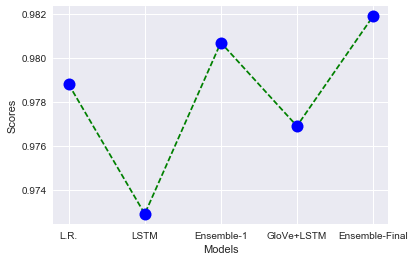

In [83]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([0.9788, 0.9729, 0.9807, 0.9769, 0.9819])
my_xticks = ['L.R.', 'LSTM', 'Ensemble-1', 'GloVe+LSTM', 'Ensemble-Final']
plt.xticks(x, my_xticks)
plt.plot(x, y, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel("Models")
plt.ylabel("Scores")
plt.show()